<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter11Design/codedIllumination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shape analysis with coded illumination
### David Brady
### University of Arizona
### December 2023

This  notebook considers the use of a CNN to reconstruct the surface profile and reflectance of simple model objects based on the MNIST data set of hand drawn digits. We assume that the MNIST data set value represents the  height of the digit and we select the reflectance from low frequency random sign patterns.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from scipy.ndimage import zoom, gaussian_filter
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
trainOrder=np.random.permutation(len(x_train))
testOrder=np.random.permutation(len(x_test))
%matplotlib inline


2024-11-12 13:26:20.915551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 13:26:20.995839: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 13:26:21.343699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-11-12 13:26:21.343734: W tensorflow/compiler/xla/stream_executor/platfo

## model training objects


We consider the digits as 3d objects. Each object has a surface reflectance and a height. Making with the objects as 128 by 128 pixel images, each object is described by a 128 by 128 height map and a 128 by 128 image map.

As a simple example, lets assume that the MNIST data is height data but that the reflectance of each digit is proportional the product of its height and another digit in the data base

Text(0.5, 1.0, 'reflectance')

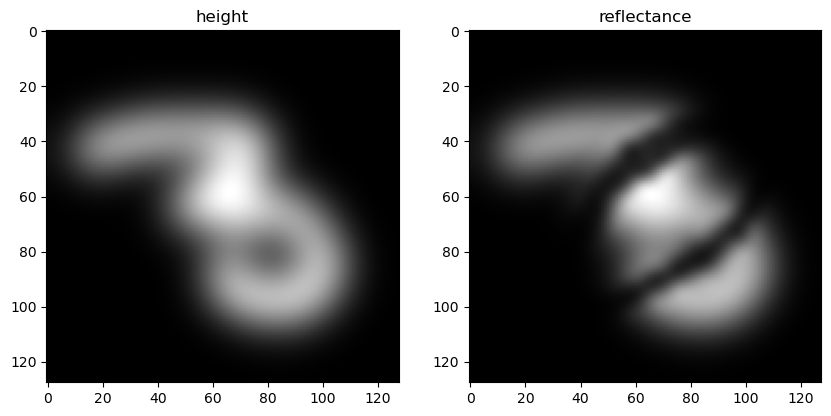

In [2]:
height = gaussian_filter(zoom(x_train[30],128/28.),8)
reflectance= height*gaussian_filter(zoom((1.2-x_train[trainOrder[30]])/.2,128/28.),2)
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(height, cmap='gray')
plt.title('height')
plt.subplot(1,2,2)
plt.imshow(reflectance, cmap='gray')
plt.title('reflectance')

Here is a visualization of what the 3D object with reflectance might look like

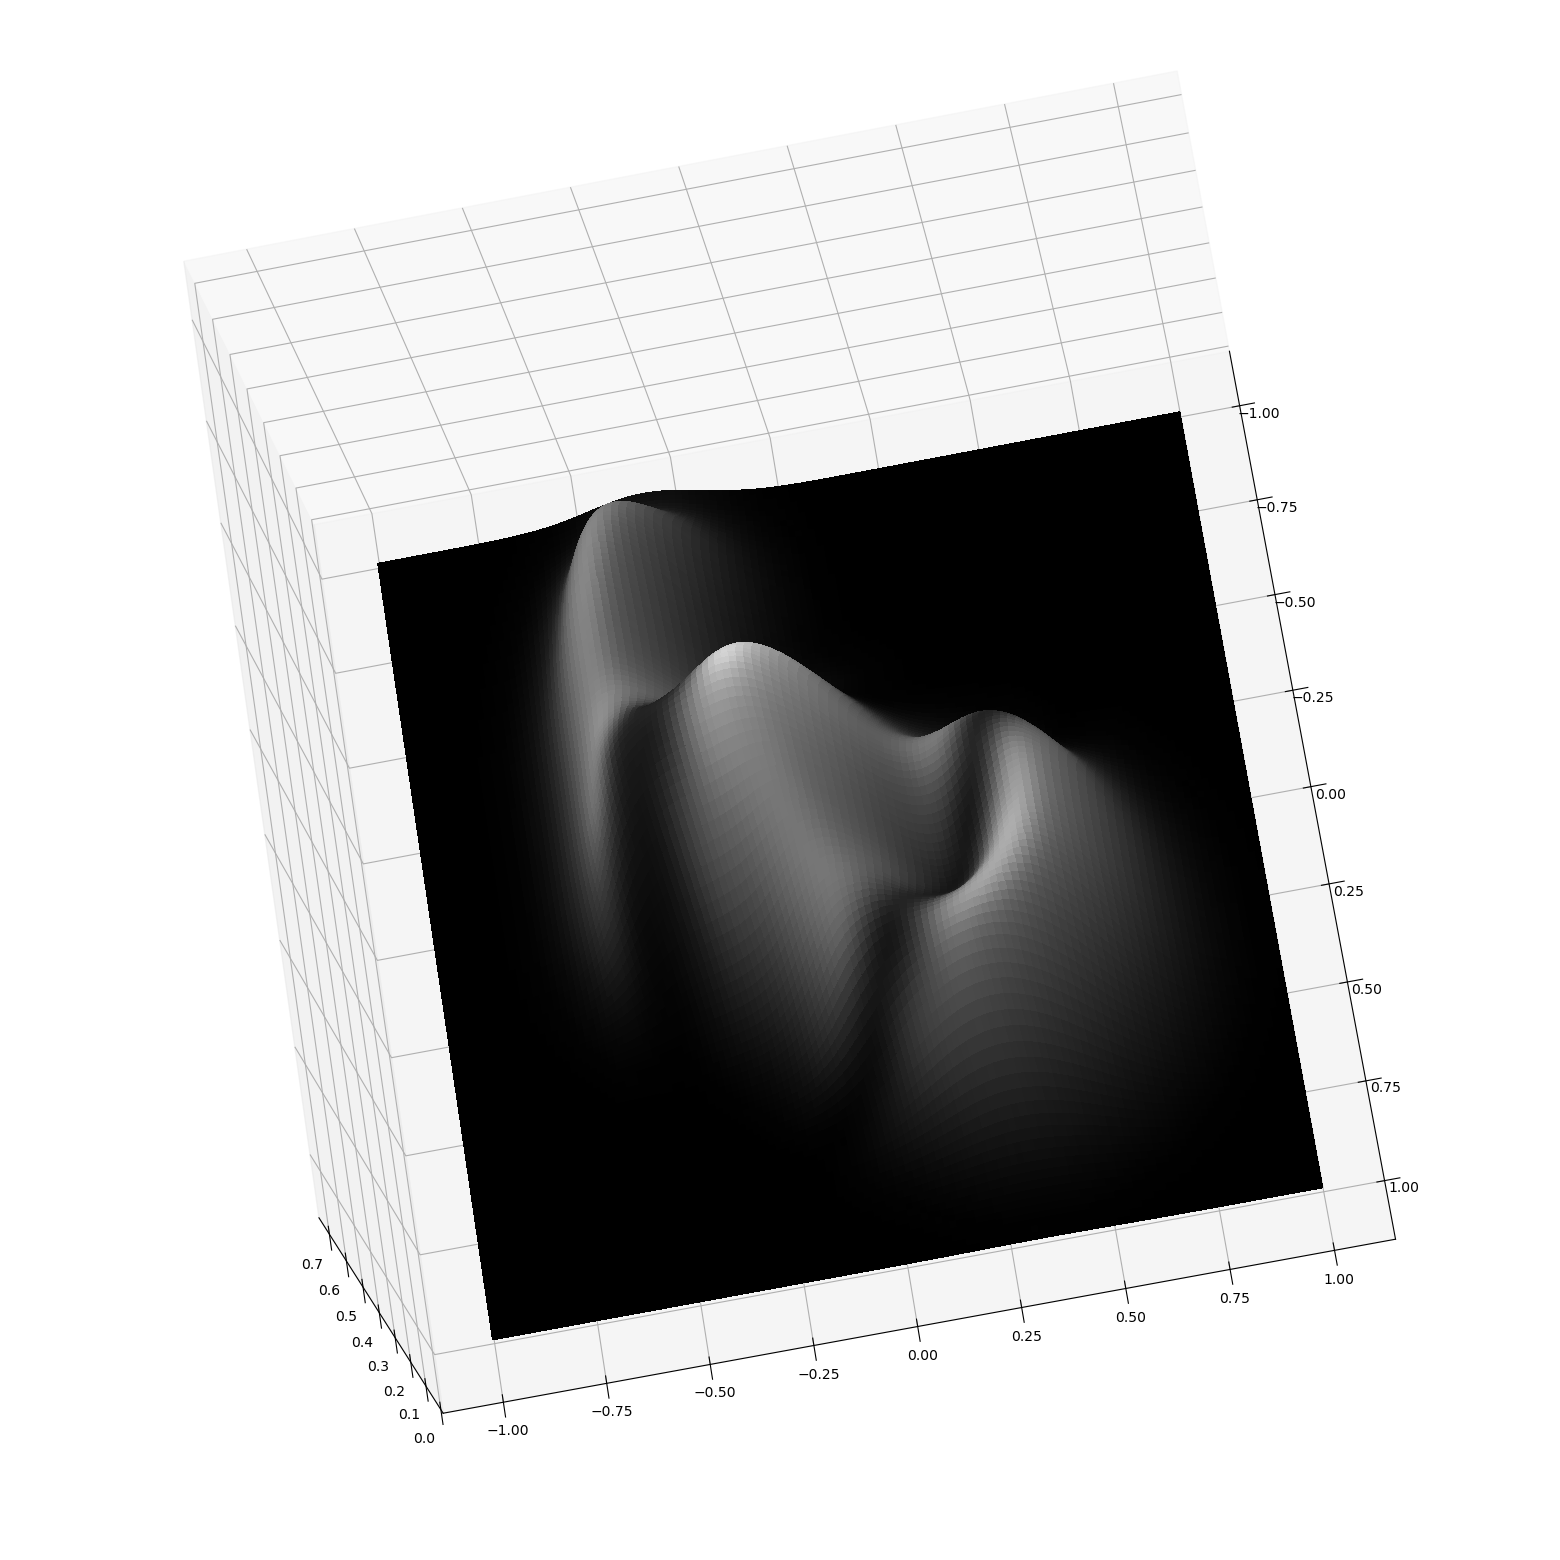

In [3]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,20))

# Make data.
ax.view_init(elev=70, azim=10, roll=20)


X = np.linspace(-1,1,128)
X, Y = np.meshgrid(X, X)
cmI = cm.gray(reflectance/np.max(reflectance))

# Plot the surface.
surf = ax.plot_surface(X, Y,height , rstride=1, cstride=1, facecolors=cmI,
                       linewidth=0, antialiased=False)
plt.savefig('codedExampleObject.png')

# creating the illumination modulated objects

## Illumination code

In [4]:
def illumination(x,y):
  a=np.abs(1+np.sin(300*np.pi*x)*np.sin(300*np.pi*y))
  return a

## Measured Image

In [5]:
def measuredImage(height, reflectance):
  # returns observed image for an object illuminated by the illumination code through the illumination cop and observed at through the observation cop.
  # The observed image is scaled cover approximately 128 by 128 pixels. (this is the magnification. The observing angluar range is set by the range to the object. )
  # height is a 128 by 128 image of the object height
  # reflectance is a 128 by 128 image of the object reflecance
  ##
  # camera center of projection
  X = np.linspace(-14,14,128)
  X, Y = np.meshgrid(X, X)
  imageCOP=np.array([0,0,10])
  # illumination center of projection
  illuminationCOP=np.array([5,-1,10])
  x=np.linspace(-1,1,128)
  # the illumination vector returns the points in projective space from the illumination that illuminate the object points.
  illuminationVector=np.zeros((128,128,3))
  # the image vector returns the points in projective space for the camera on the object.
  imageVector=np.zeros((128,128,3))
  # image points are points in camera space corresponding to points in image space
  imagePoints=np.zeros((128**2,2))
  imageValues=np.zeros((128**2))
  for ptx in range(128):
    for pty in range(128):
      illuminationVector[ptx,pty,:]=[x[ptx], x[pty],height[ptx,pty]]-illuminationCOP
      illuminationVector[ptx,pty,:]=illuminationVector[ptx,pty,:]/np.linalg.norm(illuminationVector[ptx,pty,:])
      imageVector[ptx,pty,:]=[x[ptx], x[pty],height[ptx,pty]]-imageCOP
      imageVector[ptx,pty,:]=imageVector[ptx,pty,:]/np.linalg.norm(imageVector[ptx,pty,:])
      imagePoints[ptx*128+pty,:]=[imageVector[ptx,pty,0],imageVector[ptx,pty,1]]
      imageValues[ptx*128+pty]=illumination(illuminationVector[ptx,pty,0],illuminationVector[ptx,pty,1])*reflectance[ptx,pty]
  image=griddata(imagePoints,imageValues,(.008*X,.008*Y),method='linear', fill_value=0)
  image=np.transpose(image)
  return image


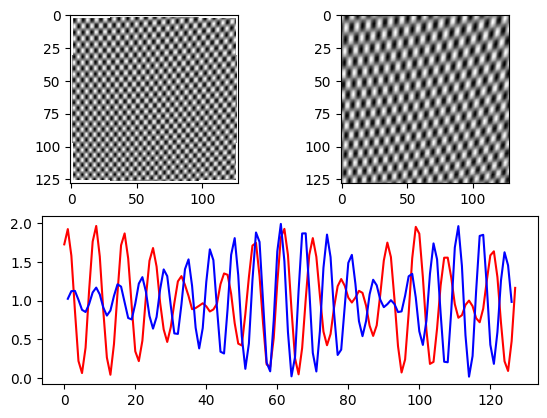

In [ ]:
plt.subplot(2,2,1)
pop=measuredImage(np.ones((128,128)),np.ones((128,128)))
plt.imshow(pop,cmap='gray')
plt.subplot(2,2,2)
pip=measuredImage(5*np.ones((128,128)),np.ones((128,128)))
plt.imshow(pip,cmap='gray')
plt.subplot(2,1,2)
plt.plot(pip[60,:],'r')
plt.plot(pop[60,:],'b')

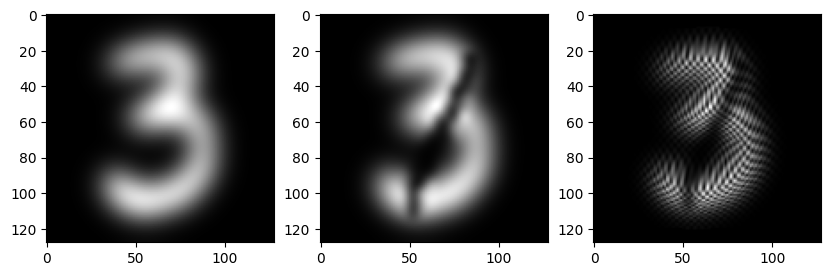

In [ ]:
plt.figure(figsize=(10,20))
height= gaussian_filter(zoom(x_train[50],128/28.),8)
reflectance = height*gaussian_filter(zoom((1.2-x_train[trainOrder[50]])/1.2,128/28.),2)
plt.subplot(1,3,1)
plt.imshow(height,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(reflectance,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(measuredImage(height, reflectance),cmap='gray')

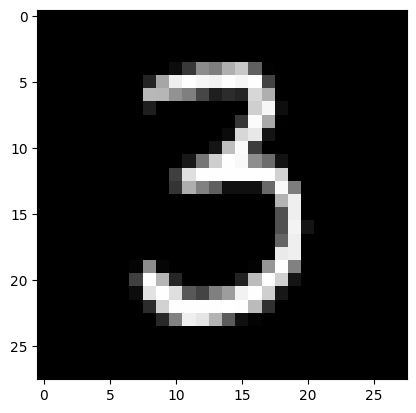

In [ ]:
-plt.imshow(x_train[50],cmap='gray')

## Training and test data

In [ ]:
f_train=np.zeros((1000,128,128,2))
f_test=np.zeros((100,128,128,2))
g_train=np.zeros((1000,128,128,1))
g_test=np.zeros((100,128,128,1))
for pop in range(1000):
  f_train[pop,:,:,0]= gaussian_filter(zoom(x_train[pop],128/28.),8)
  f_train[pop,:,:,1]= gaussian_filter(zoom((1.2-x_train[trainOrder[pop]])/1.2,128/28.),2)*np.abs(f_train[pop,:,:,0])
  g_train[pop,:,:,0]= measuredImage( f_train[pop,:,:,0], f_train[pop,:,:,1])
for pop in range(100):
  f_test[pop,:,:,0]= gaussian_filter(zoom(x_test[pop],128/28.),8)
  f_test[pop,:,:,1]= gaussian_filter(zoom((1.2-x_test[testOrder[pop]])/1.2,128/28.),2)*np.abs(f_test[pop,:,:,0])
  g_test[pop,:,:,0]= measuredImage( f_test[pop,:,:,0], f_test[pop,:,:,1])
f_train=f_train/np.max(f_train)
g_train=g_train/np.max(g_train)
f_test=f_test/np.max(f_test)
g_test=g_test/np.max(g_test)
np.savez('g_train',g_train=g_train, f_train=f_train, g_test=g_test, f_test=f_test)



In [ ]:
!cp g_train.npz drive/MyDrive/data/g_train.npz

In [ ]:
#!cp drive/MyDrive/data/g_train.npz .
data=np.load('g_train.npz')
g_train=data['g_train']
f_train=data['f_train']
g_test=data['g_test']
f_test=data['f_test']

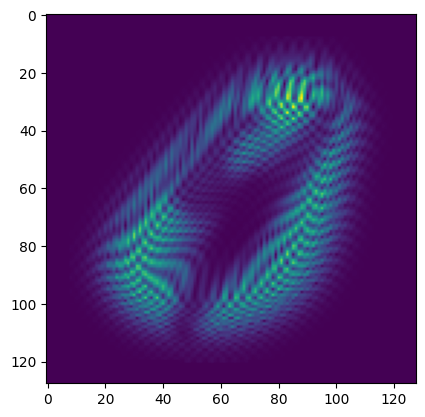

In [ ]:
plt.imshow(g_train[689,:,:,:])

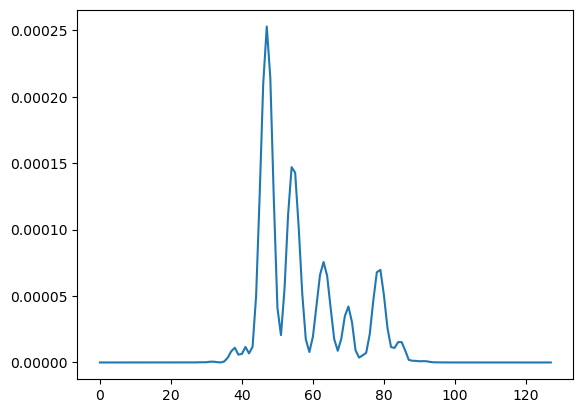

In [ ]:
plt.plot(g_train[100,:,34,0])

## Estimation Model

here we reuse the model used to recover images from gabor holograms

In [ ]:

inputs=keras.Input(shape=(128, 128, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="gelu", padding="same")(inputs)
x = layers.Conv2D(64, (4, 4), strides=2, activation="gelu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=1, activation="gelu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="gelu", padding="same")(x)
x = layers.Conv2DTranspose(2, (3, 3), activation="linear", padding="same")(x)

objectEstimator = keras.Model(inputs, x)
objectEstimator.compile(optimizer='adam', loss='mean_squared_error')
objectEstimator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 64)        36928     
 anspose)                                                    

In [ ]:
objectEstimator.fit(
    x=g_train,
    y=f_train,
    epochs=200,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, f_test),
)

Epoch 1/200
8/8 [==============================] - 1s 115ms/step - loss: 7.0856e-04 - val_loss: 0.0014
Epoch 2/200
8/8 [==============================] - 1s 104ms/step - loss: 7.1094e-04 - val_loss: 0.0013
Epoch 3/200
8/8 [==============================] - 1s 104ms/step - loss: 7.2449e-04 - val_loss: 0.0012
Epoch 4/200
8/8 [==============================] - 1s 104ms/step - loss: 7.1879e-04 - val_loss: 8.9861e-04
Epoch 5/200
8/8 [==============================] - 1s 104ms/step - loss: 7.3845e-04 - val_loss: 0.0013
Epoch 6/200
8/8 [==============================] - 1s 104ms/step - loss: 7.0220e-04 - val_loss: 0.0010
Epoch 7/200
8/8 [==============================] - 1s 104ms/step - loss: 7.0801e-04 - val_loss: 9.4490e-04
Epoch 8/200
8/8 [==============================] - 1s 103ms/step - loss: 6.9797e-04 - val_loss: 0.0012
Epoch 9/200
8/8 [==============================] - 1s 104ms/step - loss: 6.8184e-04 - val_loss: 0.0010
Epoch 10/200
8/8 [==============================] - 1s 104ms/step

In [ ]:
objectEstimator.save('objectEstimator')
!tar -czvf objectEstimator.tar.gz objectEstimator/

objectEstimator/
objectEstimator/variables/
objectEstimator/variables/variables.data-00000-of-00001
objectEstimator/variables/variables.index
objectEstimator/fingerprint.pb
objectEstimator/keras_metadata.pb
objectEstimator/saved_model.pb
objectEstimator/assets/


1/1 [==============================] - 0s 13ms/step


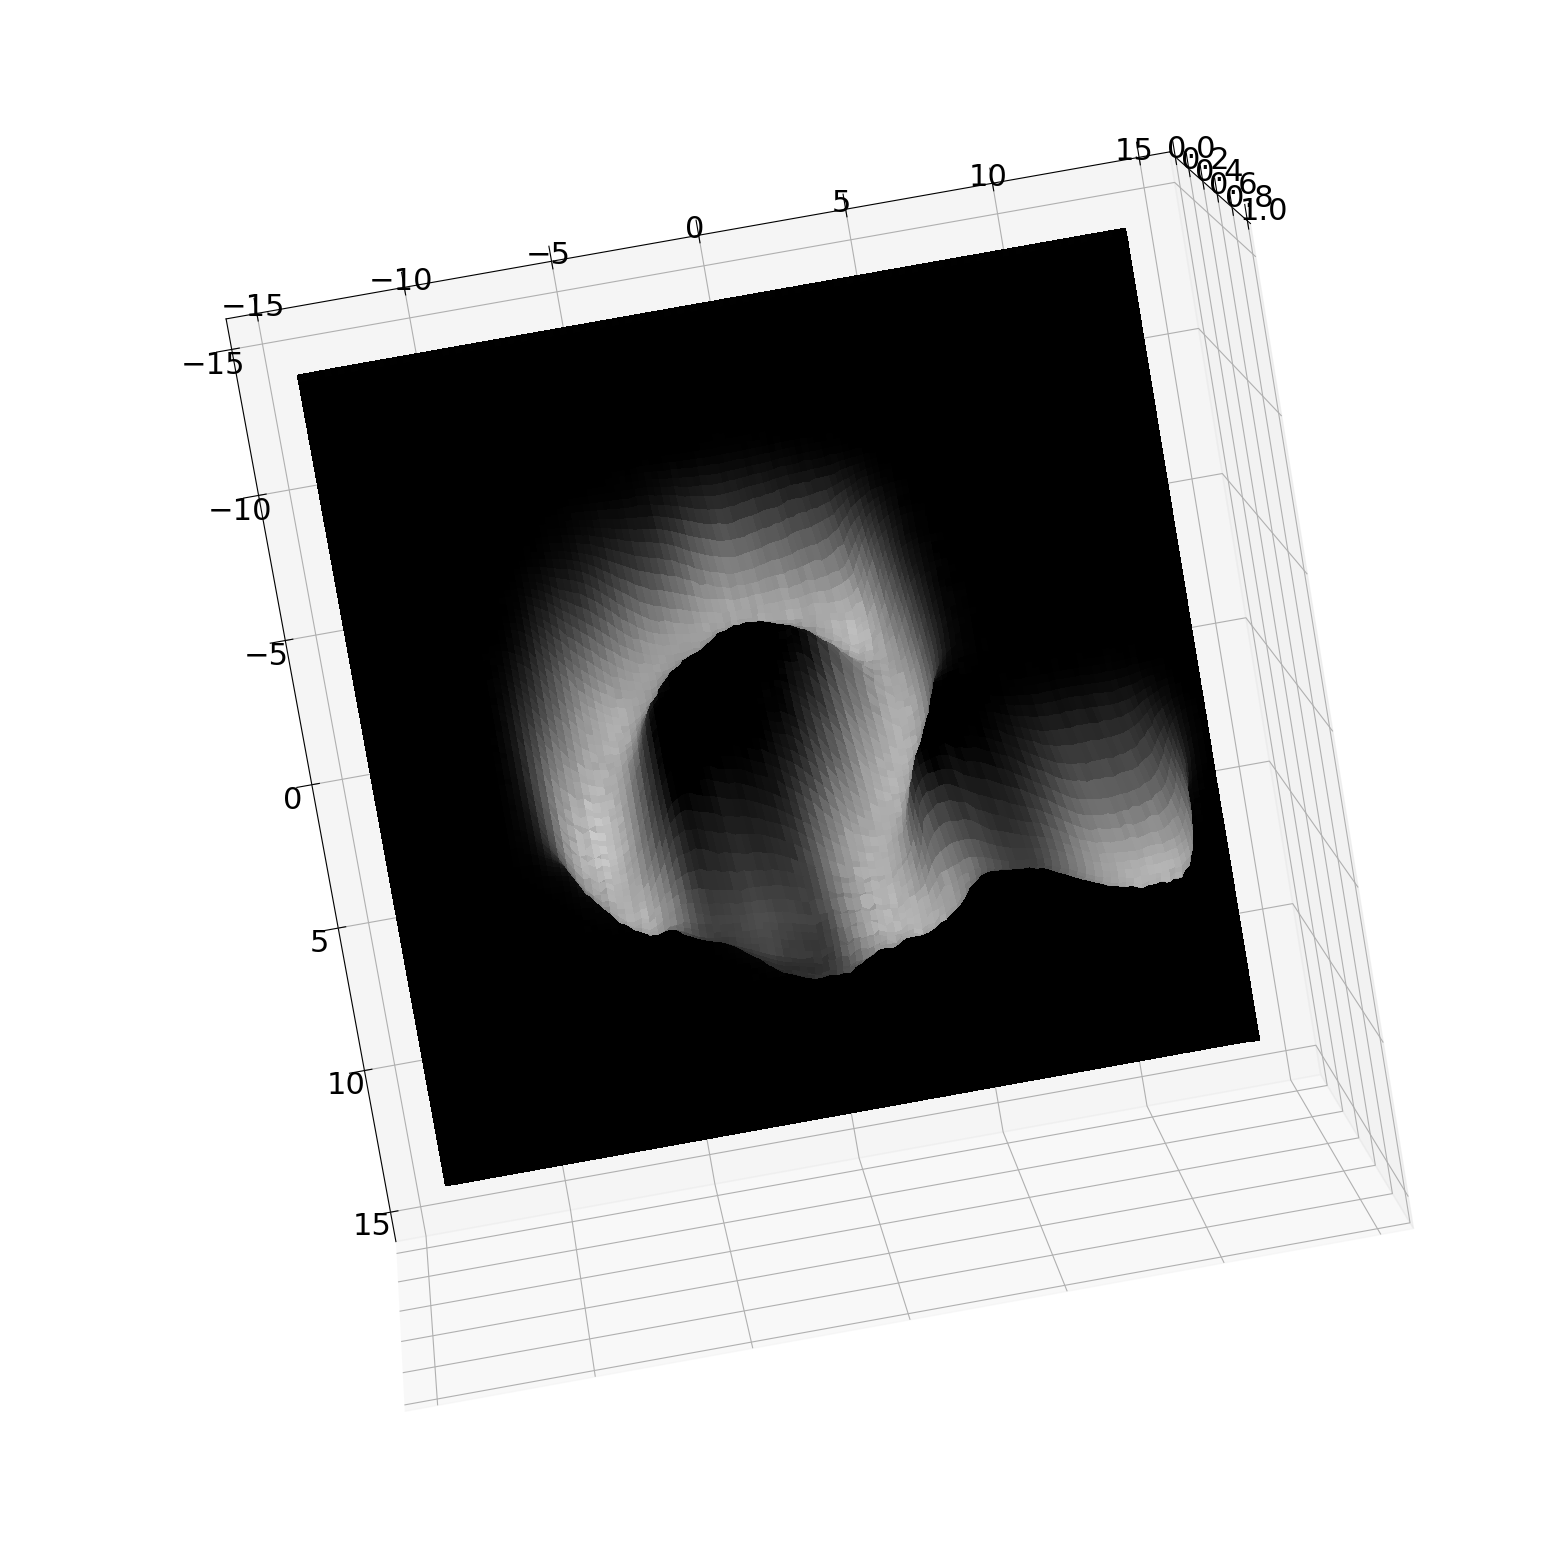

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,20))

# Make data.
ax.view_init(elev=100, azim=10, roll=20)

object= objectEstimator.predict(g_test[99:100,:,:,:])
height = object[:,:,:,0][0,:,:]
reflectance = object[:,:,:,1][0,:,:]
X = np.linspace(-14,14,128)
X, Y = np.meshgrid(X, X)
cmI = cm.gray(reflectance/np.max(reflectance))

# Plot the surface.
surf = ax.plot_surface(X, Y,height , rstride=1, cstride=1, facecolors=cmI,
                       linewidth=0, antialiased=False)
plt.savefig('codedExampleObject.png')

1/1 [==============================] - 0s 17ms/step


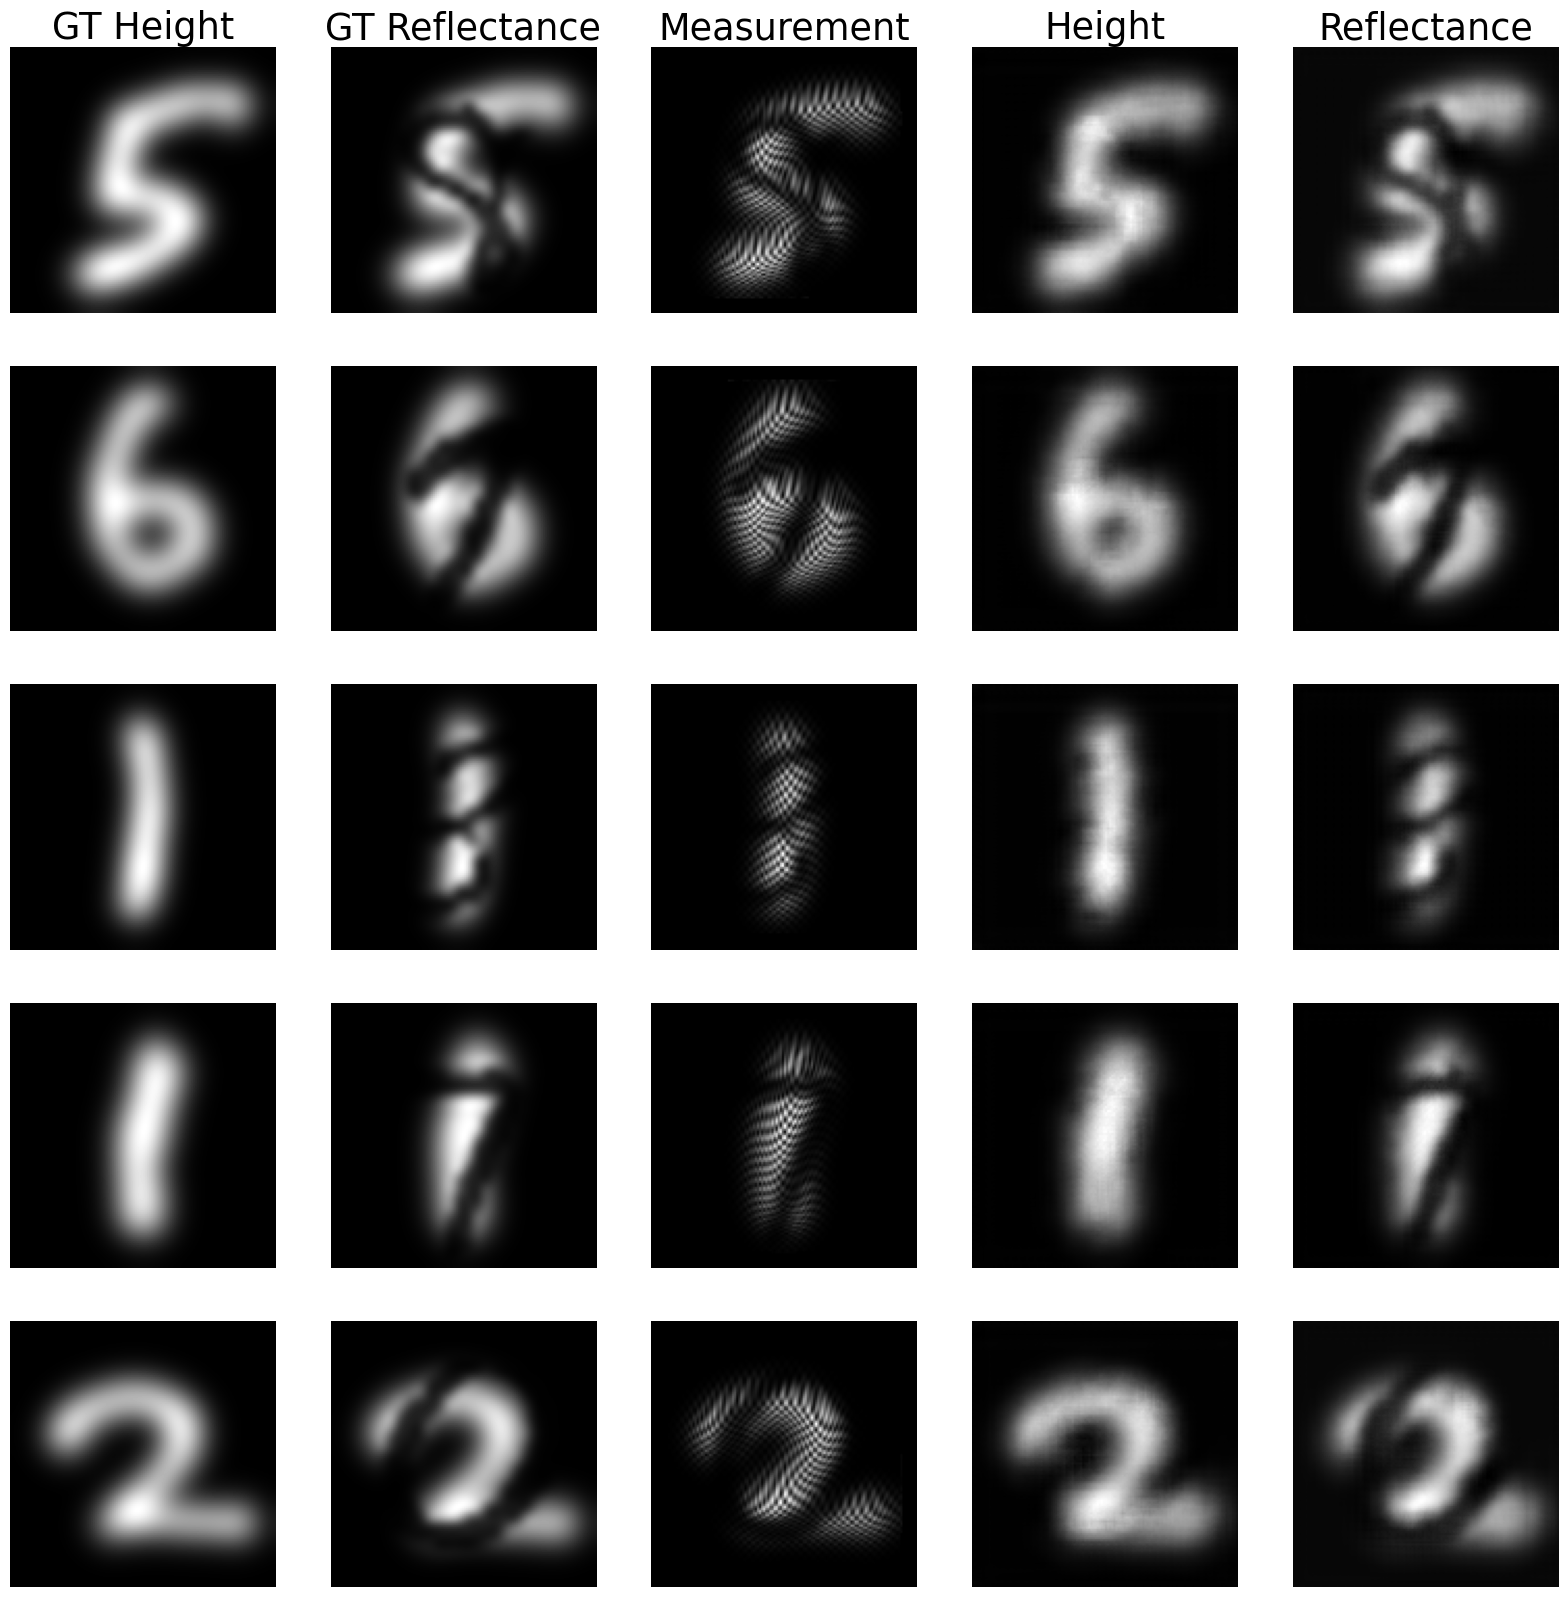

In [ ]:
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 22})
plt.rcParams['image.cmap'] = 'gray'
images= np.random.randint(0,100,5)
for pop in range(5):
  height = objectEstimator.predict(g_test[images[pop]:images[pop]+1,:,:,:])
  reflectance = height[:,:,:,1][0,:,:]
  height = height[:,:,:,0][0,:,:]
  plt.subplot(5,5,5*pop+1)
  plt.imshow(f_test[images[pop],:,:,0])
  if pop==0:
    plt.title('GT Height')
  plt.axis('off')
  plt.subplot(5,5,5*pop+2)
  plt.imshow(f_test[images[pop],:,:,1])
  if pop==0:
    plt.title('GT Reflectance')
  plt.axis('off')
  plt.subplot(5,5,5*pop+3)
  plt.imshow(g_test[images[pop],:,:,0])
  if pop==0:
    plt.title('Measurement')
  plt.axis('off')
  plt.subplot(5,5,5*pop+4)
  plt.imshow(height)
  if pop==0:
    plt.title('Height')
  plt.axis('off')
  plt.subplot(5,5,5*pop+5)
  plt.imshow(reflectance)
  if pop==0:
    plt.title('Reflectance')
  plt.axis('off')

plt.savefig('codedIllumination.png')


1/1 [==============================] - 0s 18ms/step


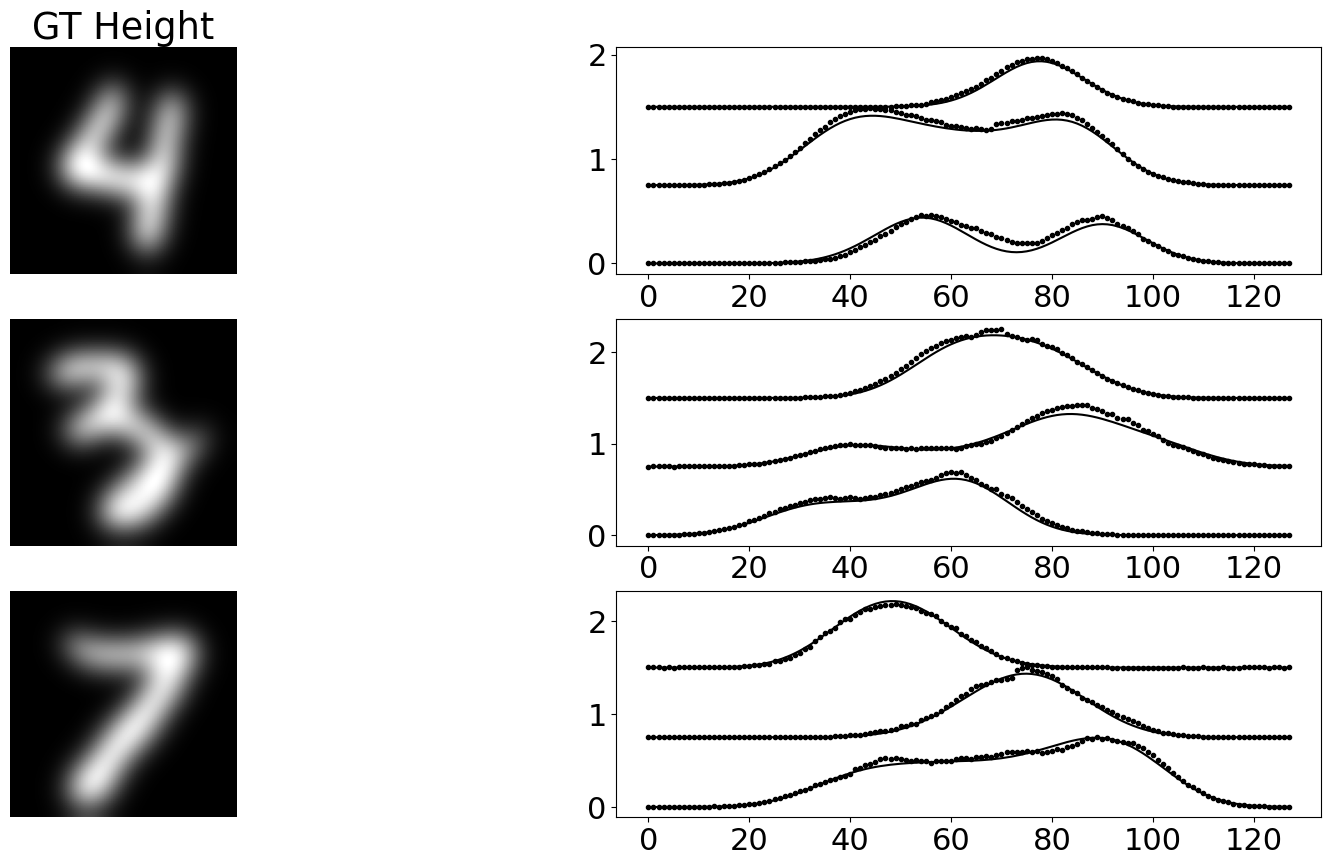

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.rcParams['image.cmap'] = 'gray'
images= np.random.randint(0,100,3)
for pop in range(3):
  height = objectEstimator.predict(g_test[images[pop]:images[pop]+1,:,:,:])
  reflectance = height[:,:,:,1][0,:,:]
  height = height[:,:,:,0][0,:,:]
  plt.subplot(3,2,2*pop+1)
  plt.imshow(f_test[images[pop],:,:,0])
  if pop==0:
    plt.title('GT Height')
  plt.axis('off')
  plt.subplot(3,2,2*pop+2)
  plt.plot(range(128),f_test[images[pop],35,:,0], 'k-',range(128), height[35,:],'k.')
  plt.plot(range(128),f_test[images[pop],70,:,0]+.75, 'k-', range(128), height[70,:]+.75,'k.')
  plt.plot(range(128),f_test[images[pop],105,:,0]+1.5,'k-', range(128), height[105,:]+1.5,'k.')

plt.savefig('codedIlluminationCross.png')

## Spatial frequencies vs. range in an example image

In [ ]:
!wget --no-check-certificate --content-disposition 'https://github.com/arizonaCameraLab/computationalImaging/raw/master/images/yogaMat.npz'
ym=np.load('yogaMat.npz')['ym']

--2023-12-18 15:34:42--  https://github.com/arizonaCameraLab/computationalImaging/raw/master/images/yogaMat.npz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/arizonaCameraLab/computationalImaging/master/images/yogaMat.npz [following]
--2023-12-18 15:34:42--  https://raw.githubusercontent.com/arizonaCameraLab/computationalImaging/master/images/yogaMat.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1396073 (1.3M) [application/octet-stream]
Saving to: ‘yogaMat.npz.1’

yogaMat.npz.1       100%[===================>]   1.33M  --.-KB/s    in 0.06s   

2023-12-18 15:34:43 (23.1 MB/s) - ‘yogaMat.n

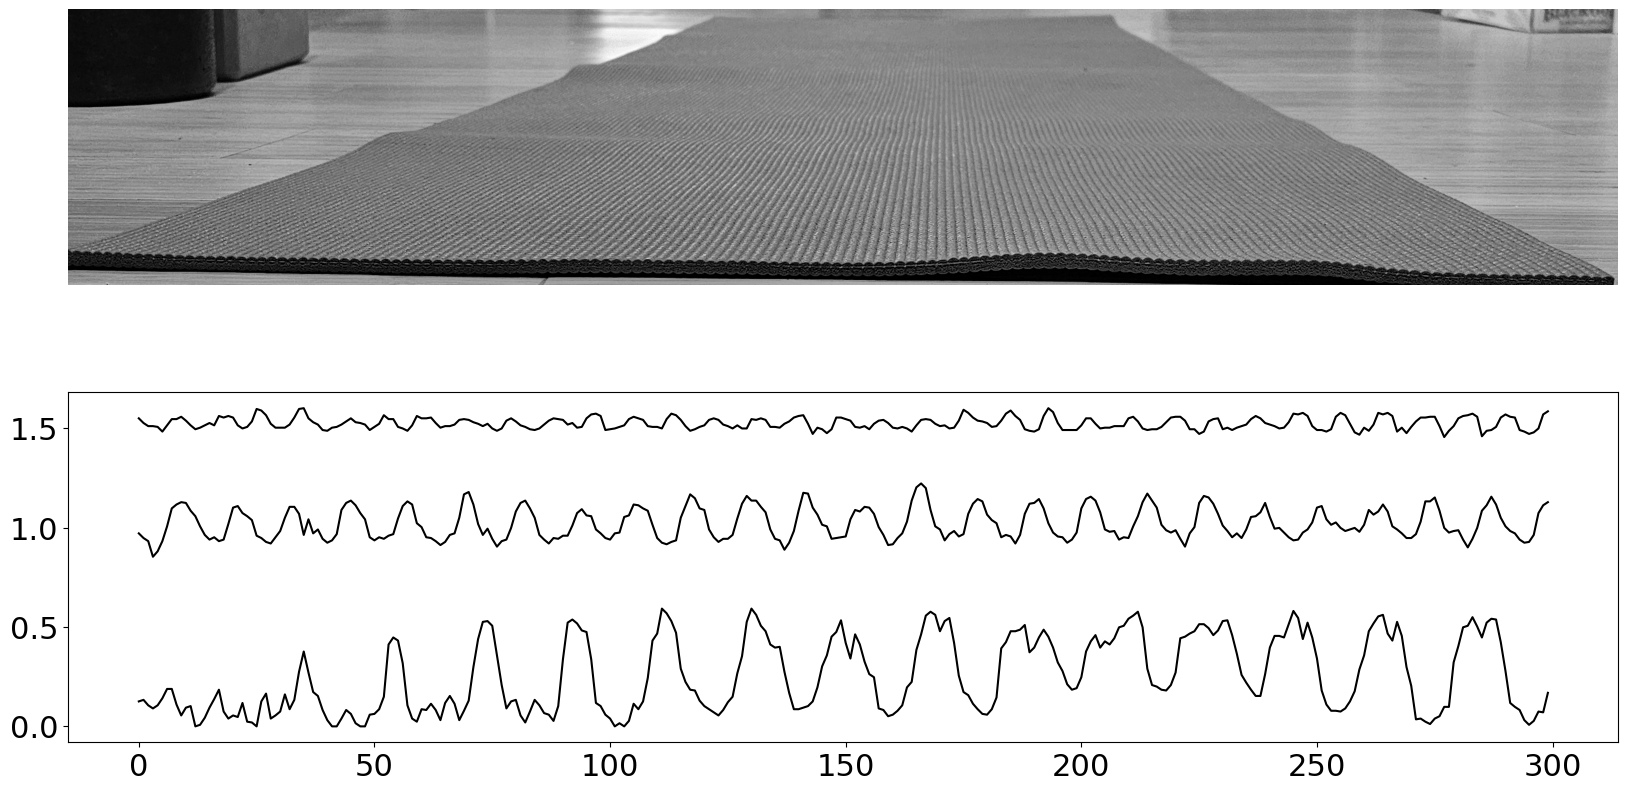

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(ym)
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(range(300),ym[150,1200:1500]+1, 'k-')
plt.plot(range(300),ym[250,1200:1500]+.5, 'k-')
plt.plot(range(300),ym[460,1200:1500], 'k-')
plt.savefig('yogaMat.png')


In [ ]:
!mv g_train.npz drive/MyDrive/g_train.npz